* Double DQN
* prioritized ER 
* gradient clipping
* 3 layers, 50 hidden dim
* $\gamma = 0.99$
* activation is softplus
* batch normalization
* optimizer is Adam and learning rate is 0.001
* the loss is the MSE (Bellman) + a penalty for going outside of (-RMAX, RMAX)
* maximum 8-10 steps of optimization for finding $argmax_{a}Q(s,a)$ with Rprop algorithm
* actions are logged. As some can be zero, we replace the zeros by the minimal action taken


In [1]:
print('ready')

ready


In [2]:
import torch as t
from torch.nn import ReLU, SELU, LeakyReLU
import numpy as np
from random import random, sample
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from IPython import display
from parse_dataset import *
from icnn import ICNN, ICNNBN, gradient_step_action, diff_params, loss_beyond_RMAX, clip_gradients, get_q_target, update_parameters_lag
from copy import deepcopy
from utils import variable, moving_avg
from replay_buffer import PrioritizedReplayBuffer

# Load and parse dataset

In [3]:
data = pd.read_csv('Sepsis_imp.csv')
replace_absurd_temperatures(data)
data = drop_patients_with_absurd_weights(data)
data = drop_patients_with_unrealistic_HR_or_BP(data)
data = add_relative_time_column(data)
data = drop_patient_with_negative_input(data)
add_small_quantities(data)
create_action_column(data)
add_log_actions(data)

log_scaler = StandardScaler()
scaler = StandardScaler()
action_scaler = StandardScaler()
train_idx, test_idx = split_train_test_idx(data)

# scale on train data only
scaler.fit(data.loc[data.icustayid.isin(train_idx)][numerical_columns_not_to_be_logged])
log_scaler.fit(np.log(data.loc[data.icustayid.isin(train_idx)][numerical_columns_to_be_logged]))
action_scaler.fit(data.loc[data.icustayid.isin(train_idx)][log_action_cols])

StandardScaler(copy=True, with_mean=True, with_std=True)

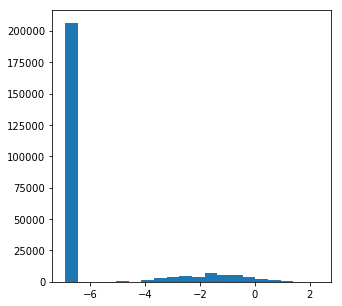

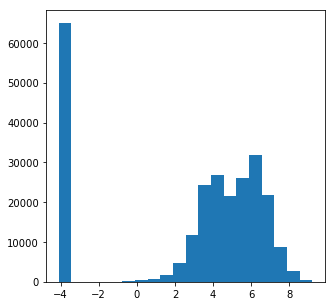

In [4]:
plt.rcParams['figure.figsize'] = (5,5)
plt.hist(data.log_vaso, bins=20)
plt.show()
plt.hist(data.log_fluid, bins=20)
plt.show()

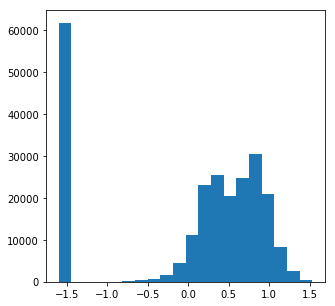

In [5]:
plt.hist(action_scaler.transform(data.loc[data.icustayid.isin(train_idx)][log_action_cols])[:,1], bins=20)
plt.show()

Split train/test

In [6]:
train_idx, test_idx = split_train_test_idx(data)

List of transitions `(s,a,r,s')`

In [7]:
transitions_train = transition_iterator(data, train_idx, scaler, log_scaler, action_scaler, RMAX=15, log_action=True)

C:\Users\sebastien\anaconda_notebook\cs282-f17-sebastian-camilo\parse_dataset.py:264: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if idx == None:


In [8]:
transitions_test = transition_iterator(data, test_idx, scaler, log_scaler, action_scaler, RMAX=15, log_action=True)

C:\Users\sebastien\anaconda_notebook\cs282-f17-sebastian-camilo\parse_dataset.py:264: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if idx == None:


In [9]:
transitions_dict = {k: {
    "s": values[0],
    "a": values[1],
    "r": values[2],
    "s'": values[3]   
}
 for k, values in enumerate(transitions_train)
}

Compute bounds for the actions (you don't have right to prescribe less than the min or more than the max). It gives bounds to the possible actions and ensure that the max of Q can actually be found

In [10]:
min0 = min([d['a'][0] for k, d in transitions_dict.items()])
max0 = max([d['a'][0] for k, d in transitions_dict.items()])
min1 = min([d['a'][1] for k, d in transitions_dict.items()])
max1 = max([d['a'][1] for k, d in transitions_dict.items()])

### Build neural network
The neural network is convex in $a$

$$u_0 = s$$
$$z_0 = a$$
$$u_{i+1} = \tilde{g}_i(\tilde{W}_iu_i+b_i)$$
$$z_{i+1} = g_i\left(W_i^{(z)}(z_i \cdot (W_i^{(zu)}u_i+b_i^{(z)})_+) + W_i^{(a)}(a \cdot (W_i^{(au)}u_i+b_i^{(a)})) + W_i^{(u)}u_i+b_i\right)$$
with $$W_i^{(z)}\geq 0$$


In [11]:
# Q_select = ICNN(3, 50, activation=SELU())
Q_select = ICNNBN(3, 50, LeakyReLU(-1.))
Q_eval = deepcopy(Q_select)
Q_eval.eval()

ICNNBN (
  (activation): Softplus (beta=1, threshold=20)
  (u0): Linear (50 -> 50)
  (bn_u0): BatchNorm1d(50, eps=0.001, momentum=0.99, affine=True)
  (u1): Linear (50 -> 50)
  (bn_u1): BatchNorm1d(50, eps=0.001, momentum=0.99, affine=True)
  (z_u0): Linear (50 -> 50)
  (bn_z_u0): BatchNorm1d(50, eps=0.001, momentum=0.99, affine=True)
  (z_au0): Linear (50 -> 2)
  (bn_z_au0): BatchNorm1d(2, eps=0.001, momentum=0.99, affine=True)
  (z_au_0): Linear (2 -> 50)
  (bn_z_au_0): BatchNorm1d(50, eps=0.001, momentum=0.99, affine=True)
  (z_u1): Linear (50 -> 50)
  (bn_z_u1): BatchNorm1d(50, eps=0.001, momentum=0.99, affine=True)
  (z_au1): Linear (50 -> 2)
  (bn_z_au1): BatchNorm1d(2, eps=0.001, momentum=0.99, affine=True)
  (z_au_1): Linear (2 -> 50)
  (bn_z_au_1): BatchNorm1d(50, eps=0.001, momentum=0.99, affine=True)
  (z_zu1): Linear (50 -> 50)
  (bn_z_zu1): BatchNorm1d(50, eps=0.001, momentum=0.99, affine=True)
  (z_zu_1): Linear (50 -> 50)
  (bn_z_zu_1): BatchNorm1d(50, eps=0.001, momentu

In [13]:
print('#params: %s' % np.sum([np.prod(p.data.numpy().shape) for p in Q_select.parameters()]))

#params: 19327


# Get PER

In [14]:
# CREATE PRIORITIZED ER EXPERIENCE BUFFER
memory = PrioritizedReplayBuffer(len(transitions_dict), .6)

for tr in shuffle(transitions_dict):
    
    # check if state is terminal
    if tr["s'"] is not None:
        s_ = tr["s'"]
        done = False
    else:
        s_ = np.array(50*[np.nan])
        done = True
    s = tr['s']
    a = tr['a']
    r = np.array([tr['r']])
    
    transition = (s,a,r,s_,done)
    memory.add(*transition)

# Train model

In [15]:
print('ready')

ready


In [16]:
def clip(x):
    """
    Clip values below -RMAX or above RMAX
    Might be useful when the target goes beyond
    """
    return x*((x>=-RMAX).float())*((x<=RMAX).float()) + RMAX*(x>RMAX).float() - RMAX*(x<-RMAX).float()

In [17]:
def test():
    n = len(transitions_test)
    for i in range(0, len(transitions_test), batch_size):
        transitions = transitions_test[i:i+batch_size]
        s = t.cat([variable(tr[0].reshape((1,50))) for tr in transitions])
        a = t.cat([variable(tr[1].reshape((1,2))) for tr in transitions])
        r = t.cat([variable(tr[2].reshape((1,1))) for tr in transitions])
        s_ = t.cat([variable(tr[3].reshape((1,50))) if tr[3] is not None else variable(np.array([50*[np.nan]])) for tr in transitions])
        Q_select.eval()
        pred = Q_select.forward(s, a).squeeze()  # Q(s, a)
        target, max_actions = get_q_target(Q_select, Q_eval, s_, r, min0, max0, min1, max1, gamma=gamma, max_steps_a=max_steps_a, return_max_actions=True)  # max_a' Q(s', a)
        Q_select.train()
        target = target.squeeze()
        if i == 0:
            td_error = t.sum(t.abs(pred-target))
            avg_Q = t.sum(pred)
            max_Q = t.max(pred)
            min_Q = t.min(pred)
        else:
            td_error += t.sum(t.abs(pred-target))
            avg_Q += t.sum(pred)
            max_Q += t.max(pred)
            min_Q += t.min(pred)
    return td_error.data.numpy()[0]/n, avg_Q.data.numpy()[0]/n, max_Q.data.numpy()[0]/(n/batch_size), min_Q.data.numpy()[0]/(n/batch_size)
        

# Idees
* lag update ?
* commencer avec une proportion egale de +15, -15, 0, et ajouter des 0 a chaque batch
* ajouter un terme dans la loss pour penaliser les valeurs extremes, avec une loss ressemblant a $(Q(s, \alpha) + 15)^2$ avec $\alpha$ le max des vasos par exemple


In [18]:
from time import time
plt.rcParams['figure.figsize'] = (20,20)

# RL parameters
global_step = -1
EPOCHS = 100
gamma = .99
max_steps_beta = 100000
beta0 = .4
beta = lambda t: (t<max_steps_beta)*(beta0 + t*(1-beta0)/max_steps_beta) + (t>=max_steps_beta)*1.
RMAX = 15
c = 1e3
T_UPDATE = 200  # parameter to copy the weights periodically

# OPTIMIZER PARAMETERS
batch_size = 32
learning_rate = 1e-3  # can have higher than default value if use BatchNorm
optimizer = t.optim.Adam(Q_select.parameters(), lr=learning_rate)
max_steps = int(len(data) / batch_size)
max_steps_a = 8

# monitoring
losses = []
td_errors = []
test_td_errors = []
test_average_q_pred = []
test_max_q_pred = []
test_min_q_pred = []
average_q_pred = []
average_q_target = []
max_q_pred = []
min_q_pred = []
max_q_target = []
min_q_target = []
average_vaso = []
max_vaso = []
min_vaso = []
average_fluid = []
max_fluid = []
min_fluid = []


# TRAIN
for _ in range(EPOCHS):
    t0 = time()
    for step in range(max_steps):
        global_step += 1

        # Sample batch
        s,a,r,s_,done,w,idx = memory.sample(batch_size, beta(global_step))
        states = variable(s)
        actions = variable(a)
        rewards = variable(r)
        next_states = variable(s_)
        weights = variable(w).squeeze()
        
        # Init grad (set all of them to zero)
        optimizer.zero_grad()

        # Compute loss
        pred = Q_select.forward(states, actions).squeeze()  # Q(s, a)
        Q_select.eval()
        target, max_actions = get_q_target(Q_select, Q_eval, next_states, rewards, min0, max0, min1, max1, gamma=gamma, max_steps_a=max_steps_a, return_max_actions=True)  # max_a' Q(s', a)
        Q_select.train()
        target = clip(target.squeeze())
        loss = (pred-target)
        loss = loss**2
        loss = loss*weights  # multiplication by the PER coefficients
        loss = t.mean(loss) + c*t.mean(loss_beyond_RMAX(pred, RMAX))
        
        # Update priorities
        td_error = t.abs(pred - target) + 1e-3
        memory.update_priorities(idx, td_error.data.numpy())
        
        # Monitoring
        losses.append(loss.data.numpy()[0])
        td_errors.append(td_error.data.numpy().mean())
        average_q_pred.append(t.mean(pred).squeeze().data.numpy()[0])
        max_q_pred.append(t.max(pred).squeeze().data.numpy()[0])
        min_q_pred.append(t.min(pred).squeeze().data.numpy()[0])
        average_q_target.append(t.mean(target).squeeze().data.numpy()[0])
        max_q_target.append(t.max(target).squeeze().data.numpy()[0])
        min_q_target.append(t.min(target).squeeze().data.numpy()[0])
        min_a = np.min(max_actions.data.numpy(), 0).squeeze()
        max_a = np.max(max_actions.data.numpy(), 0).squeeze()
        mean_a = np.mean(max_actions.data.numpy(), 0).squeeze()
        min_vaso.append(min_a[0])
        max_vaso.append(max_a[0])
        average_vaso.append(mean_a[0])
        min_fluid.append(min_a[1])
        max_fluid.append(max_a[1])
        average_fluid.append(mean_a[1])
        
        # Compute gradients and update weights of the selection network
        loss.backward()
        clip_gradients(Q_select, 10)
        optimizer.step()
        
        # Keep weights positive so that the Q_select stays concave
        Q_select.proj()
        
        # update parameters of the evaluation network. Its weights lag behind
        if global_step % T_UPDATE == 0:
            Q_eval = deepcopy(Q_select)
            Q_eval.eval()

        # PLOT
        if step % 250 == 0:
            display.clear_output(wait=True)
            
            fig, axes = plt.subplots(3, 2)
            # td error
            axes[0,0].plot(moving_avg(losses))
            axes[0,1].plot(moving_avg(td_errors))
            # Q values (target and pred)
            axes[1,0].plot(moving_avg(average_q_pred), label='avg pred', c='darkblue')
            axes[1,0].plot(moving_avg(min_q_pred), label='min pred', c='darkblue', alpha=.8,linestyle=':')
            axes[1,0].plot(moving_avg(max_q_pred), label='max pred', c='darkblue', alpha=.8,linestyle=':')
            axes[1,0].plot(moving_avg(average_q_target), label='avg target', c='crimson')
            axes[1,0].plot(moving_avg(min_q_target), label='min target', c='crimson', alpha=.8,linestyle=':')
            axes[1,0].plot(moving_avg(max_q_target), label='max target', c='crimson', alpha=.8,linestyle=':')
            axes[1,1].plot(moving_avg(average_q_pred[200:]), label='avg pred', c='darkblue')
            axes[1,1].plot(moving_avg(min_q_pred[200:]), label='min pred', c='darkblue', alpha=.8,linestyle=':')
            axes[1,1].plot(moving_avg(max_q_pred[200:]), label='max pred', c='darkblue', alpha=.8,linestyle=':')
            axes[1,1].plot(moving_avg(average_q_target[200:]), label='avg target', c='crimson')
            axes[1,1].plot(moving_avg(min_q_target[200:]), label='min target', c='crimson', alpha=.8,linestyle=':')
            axes[1,1].plot(moving_avg(max_q_target[200:]), label='max target', c='crimson', alpha=.8,linestyle=':')
            axes[1,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            # actions (vaso and fluid)
            axes[2,0].plot(moving_avg(average_fluid), label='avg fluid', c='darkblue')
            axes[2,0].plot(moving_avg(min_fluid), label='min fluid', c='darkblue', alpha=.8,linestyle=':')
            axes[2,0].plot(moving_avg(max_fluid), label='max fluid', c='darkblue', alpha=.8,linestyle=':')
            axes[2,0].plot(moving_avg(average_vaso), label='avg vaso', c='crimson')
            axes[2,0].plot(moving_avg(min_vaso), label='min vaso', c='crimson', alpha=.8,linestyle=':')
            axes[2,0].plot(moving_avg(max_vaso), label='max vaso', c='crimson', alpha=.8,linestyle=':')
            axes[2,1].plot(moving_avg(average_fluid[200:]), label='avg fluid', c='darkblue')
            axes[2,1].plot(moving_avg(min_fluid[200:]), label='min fluid', c='darkblue', alpha=.8,linestyle=':')
            axes[2,1].plot(moving_avg(max_fluid[200:]), label='max fluid', c='darkblue', alpha=.8,linestyle=':')
            axes[2,1].plot(moving_avg(average_vaso[200:]), label='avg vaso', c='crimson')
            axes[2,1].plot(moving_avg(min_vaso[200:]), label='min vaso', c='crimson', alpha=.8,linestyle=':')
            axes[2,1].plot(moving_avg(max_vaso[200:]), label='max vaso', c='crimson', alpha=.8,linestyle=':')
            axes[2,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.tight_layout()
            plt.show()
            
            print('Epoch %s\n%s steps in this epoch\n%s steps/s' % (str(_), str(step), str(step/(time()-t0))))

KeyboardInterrupt: 

In [42]:
t.mean((pred-target)**2)

Variable containing:
 142.3045
[torch.FloatTensor of size 1]

In [27]:
plt.rcParams['figure.figsize']=(5,5)
a, b = -50, 50
state = variable(np.concatenate(100*[np.random.normal(size=(1,50))], 0)).float()
actions = variable(np.array([[aa,0] for aa in np.linspace(a,b,100)])).float()
Q_select.eval()


ICNNBN (
  (activation): Softplus (beta=1, threshold=20)
  (u0): Linear (50 -> 50)
  (bn_u0): BatchNorm1d(50, eps=0.001, momentum=0.99, affine=True)
  (u1): Linear (50 -> 50)
  (bn_u1): BatchNorm1d(50, eps=0.001, momentum=0.99, affine=True)
  (z_u0): Linear (50 -> 50)
  (bn_z_u0): BatchNorm1d(50, eps=0.001, momentum=0.99, affine=True)
  (z_au0): Linear (50 -> 2)
  (bn_z_au0): BatchNorm1d(2, eps=0.001, momentum=0.99, affine=True)
  (z_au_0): Linear (2 -> 50)
  (bn_z_au_0): BatchNorm1d(50, eps=0.001, momentum=0.99, affine=True)
  (z_u1): Linear (50 -> 50)
  (bn_z_u1): BatchNorm1d(50, eps=0.001, momentum=0.99, affine=True)
  (z_au1): Linear (50 -> 2)
  (bn_z_au1): BatchNorm1d(2, eps=0.001, momentum=0.99, affine=True)
  (z_au_1): Linear (2 -> 50)
  (bn_z_au_1): BatchNorm1d(50, eps=0.001, momentum=0.99, affine=True)
  (z_zu1): Linear (50 -> 50)
  (bn_z_zu1): BatchNorm1d(50, eps=0.001, momentum=0.99, affine=True)
  (z_zu_1): Linear (50 -> 50)
  (bn_z_zu_1): BatchNorm1d(50, eps=0.001, momentu

In [31]:
rewards

Variable containing:
    0
    0
    0
    0
    0
  -15
    0
    0
    0
    0
  -15
    0
    0
    0
   15
    0
    0
    0
    0
    0
    0
    0
    0
    0
   15
    0
    0
    0
    0
  -15
    0
  -15
[torch.FloatTensor of size 32x1]

In [30]:
target

Variable containing:
 15.0000
 15.0000
 15.0000
 15.0000
 15.0000
-15.0000
 15.0000
 15.0000
 15.0000
 15.0000
-15.0000
 15.0000
 15.0000
 15.0000
 15.0000
 15.0000
 15.0000
 15.0000
 14.8976
 15.0000
 15.0000
 15.0000
 15.0000
 15.0000
 15.0000
 15.0000
 15.0000
 15.0000
 15.0000
-15.0000
 15.0000
-15.0000
[torch.FloatTensor of size 32]

In [29]:
pred

Variable containing:
 12.6436
 13.4766
 13.8448
 14.4333
 -9.1691
 12.7021
 12.8848
 13.1709
 13.2326
 12.6446
 14.6200
 10.1545
 -1.3438
 13.5700
 12.8291
 12.9865
 13.6627
 13.0036
  8.6997
 14.6383
 13.8866
 12.2882
 12.8150
 14.2299
 13.7532
 15.7066
 12.1564
 13.0250
 12.5338
 14.1350
  3.1184
 15.4794
[torch.FloatTensor of size 32]

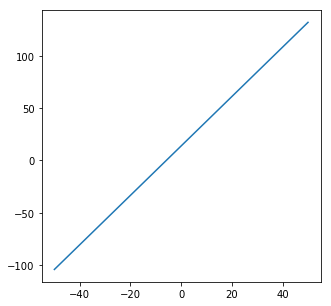

In [34]:
Qvalues = Q_select.forward(state, actions).data.numpy()
plt.plot(np.linspace(a,b,100), Qvalues)
plt.show()

# Graphs

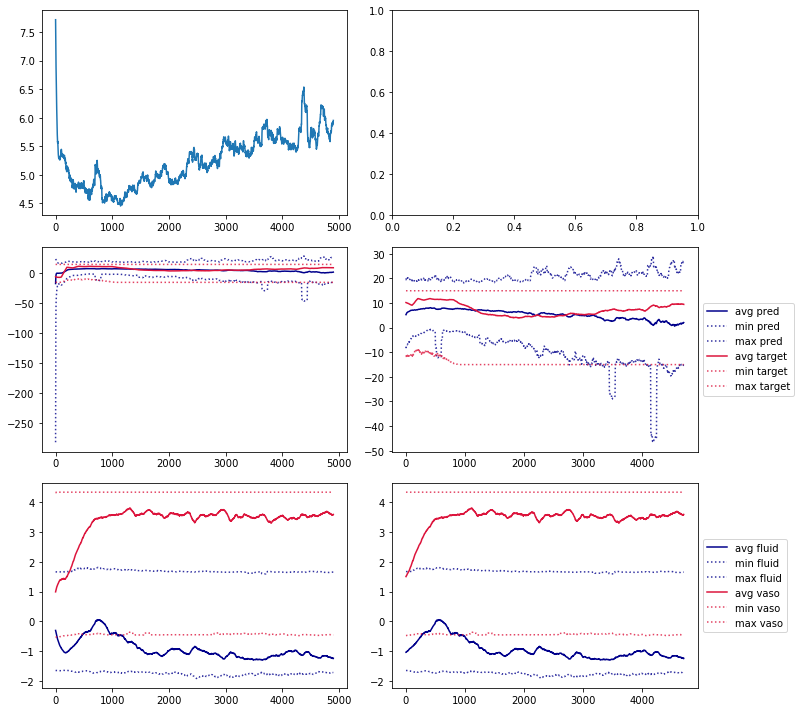

In [90]:
fig, axes = plt.subplots(3, 2)
plt.rcParams['figure.figsize'] = (20,20)
# td error
axes[0,0].plot(moving_avg(np.log(losses[:5000])))
# Q values (target and pred)
axes[1,0].plot(moving_avg(average_q_pred[:5000]), label='avg pred', c='darkblue')
axes[1,0].plot(moving_avg(min_q_pred[:5000]), label='min pred', c='darkblue', alpha=.8,linestyle=':')
axes[1,0].plot(moving_avg(max_q_pred[:5000]), label='max pred', c='darkblue', alpha=.8,linestyle=':')
axes[1,0].plot(moving_avg(average_q_target[:5000]), label='avg target', c='crimson')
axes[1,0].plot(moving_avg(min_q_target[:5000]), label='min target', c='crimson', alpha=.8,linestyle=':')
axes[1,0].plot(moving_avg(max_q_target[:5000]), label='max target', c='crimson', alpha=.8,linestyle=':')
axes[1,1].plot(moving_avg(average_q_pred[200:5000]), label='avg pred', c='darkblue')
axes[1,1].plot(moving_avg(min_q_pred[200:5000]), label='min pred', c='darkblue', alpha=.8,linestyle=':')
axes[1,1].plot(moving_avg(max_q_pred[200:5000]), label='max pred', c='darkblue', alpha=.8,linestyle=':')
axes[1,1].plot(moving_avg(average_q_target[200:5000]), label='avg target', c='crimson')
axes[1,1].plot(moving_avg(min_q_target[200:5000]), label='min target', c='crimson', alpha=.8,linestyle=':')
axes[1,1].plot(moving_avg(max_q_target[200:5000]), label='max target', c='crimson', alpha=.8,linestyle=':')
axes[1,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# actions (vaso and fluid)
axes[2,0].plot(moving_avg(average_fluid[:5000]), label='avg fluid', c='darkblue')
axes[2,0].plot(moving_avg(min_fluid[:5000]), label='min fluid', c='darkblue', alpha=.8,linestyle=':')
axes[2,0].plot(moving_avg(max_fluid[:5000]), label='max fluid', c='darkblue', alpha=.8,linestyle=':')
axes[2,0].plot(moving_avg(average_vaso[:5000]), label='avg vaso', c='crimson')
axes[2,0].plot(moving_avg(min_vaso[:5000]), label='min vaso', c='crimson', alpha=.8,linestyle=':')
axes[2,0].plot(moving_avg(max_vaso[:5000]), label='max vaso', c='crimson', alpha=.8,linestyle=':')
axes[2,1].plot(moving_avg(average_fluid[200:5000]), label='avg fluid', c='darkblue')
axes[2,1].plot(moving_avg(min_fluid[200:5000]), label='min fluid', c='darkblue', alpha=.8,linestyle=':')
axes[2,1].plot(moving_avg(max_fluid[200:5000]), label='max fluid', c='darkblue', alpha=.8,linestyle=':')
axes[2,1].plot(moving_avg(average_vaso[200:5000]), label='avg vaso', c='crimson')
axes[2,1].plot(moving_avg(min_vaso[200:5000]), label='min vaso', c='crimson', alpha=.8,linestyle=':')
axes[2,1].plot(moving_avg(max_vaso[200:5000]), label='max vaso', c='crimson', alpha=.8,linestyle=':')
axes[2,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# save model

In [96]:
t.save(Q_select.state_dict(), 'icnn.3layers.50hdim.41epochs.nosigmoid.pytorch')

# Test values

In [18]:
max_q_pred[-50:]

[14.923473,
 14.923453,
 14.923435,
 14.923414,
 14.923396,
 14.923374,
 14.923357,
 14.923335,
 14.923317,
 14.923296,
 14.923278,
 14.923257,
 14.923239,
 14.923218,
 14.9232,
 14.923178,
 14.923161,
 14.923139,
 14.923117,
 14.923101,
 14.923079,
 14.923061,
 14.92304,
 14.923022,
 14.923001,
 14.922983,
 14.922961,
 14.92294,
 14.922922,
 14.922901,
 14.922883,
 14.922861,
 14.922844,
 14.922822,
 14.922801,
 14.922783,
 14.922761,
 14.922742,
 14.922724,
 14.922703,
 14.922685,
 14.922663,
 14.922642,
 14.922624,
 14.922602,
 14.922581,
 14.922563,
 14.922542,
 14.92252,
 14.922503]

In [24]:
np.mean(average_q_pred[-50:])

3.2619476

In [19]:
target, max_actions = get_q_target(Q_select, Q_eval, next_states, rewards, min0, max0, min1, max1, gamma=gamma, max_steps_a=max_steps_a, return_max_actions=True)  # max_a' Q(s', a)

In [20]:
max_actions

Variable containing:
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
    0     0
[torch.FloatTensor of size 49x2]

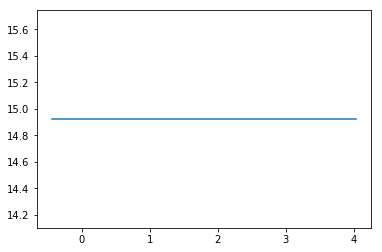

In [22]:
arange = np.linspace(min0,max0,100)
n = arange.shape[0]
a = variable(np.array([[aa,0.] for aa in arange])).float()
s = t.cat(n*[states[:1]])
Qvalues = Q_select.forward(s, a).data.numpy()
plt.plot(arange,Qvalues)
plt.show()

In [23]:
target

Variable containing:
-15.0000
-15.0000
-15.0000
-15.0000
-15.0000
-15.0000
-15.0000
-15.0000
-15.0000
-15.0000
-15.0000
-15.0000
-15.0000
-15.0000
 14.6253
 14.6253
-15.0000
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
 14.6253
[torch.FloatTensor of size 64]

Note that the **log batch-averaged loss** is plotted

In [21]:
rewards

Variable containing:
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
    0
  -15
  -15
    0
    0
    0
    0
    0
    0
    0
  -15
    0
    0
    0
    0
    0
    0
    0
[torch.FloatTensor of size 64x1]

In [25]:
Q_eval(next_states,actions)

Variable containing:
  28.4563
 148.5353
 108.7014
-141.9309
  75.2661
 -75.8976
  -2.0415
  84.1697
  23.4179
  22.8115
  14.6229
  19.6716
  28.7770
  18.8936
  16.4613
  17.6385
  30.5715
  16.4891
   0.7122
  24.0434
  17.2358
  16.1694
  16.5111
  15.5321
  20.1218
  -5.7534
  11.0557
  18.2607
  12.8817
 -15.1665
  13.0907
  14.7033
  15.6846
  15.8474
  21.2077
  14.1347
  17.8210
  12.1388
  17.6575
  18.7089
  14.1716
  16.0359
  14.0638
   2.6963
  12.5733
  12.5238
  18.1778
      nan
      nan
      nan
  10.4622
  10.7528
  13.6480
   1.4924
  11.7418
  12.6888
      nan
  14.2888
      nan
   7.8551
      nan
   9.6255
   6.1235
  14.3881
[torch.FloatTensor of size 64x1]

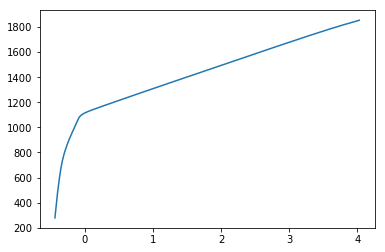

In [32]:
a_range = np.arange(min0,max0,1e-2)
n = a_range.shape[0]
a = variable(np.array([[aa,0.] for aa in a_range]))
plt.plot(a_range,Q_eval(t.cat(n*[next_states[:1]]), a).squeeze().data.numpy())
plt.show()

In [ ]:
Q_eval(next_states)

In [38]:
get_q_target(Q_select, Q_eval, next_states, rewards, min0, max0, min1, max1, gamma=gamma, max_steps_a=10)

Variable containing:
 1790.2780
 1643.3878
 1787.9060
 1496.0699
  789.2684
 1406.1121
  104.9660
  263.5234
  104.6287
  121.8344
  101.7226
   90.2202
  119.5100
   99.4207
   84.2035
   95.4223
  133.9977
   72.4200
  104.3044
   78.6366
   63.3387
  111.6996
   62.9658
   73.4466
   58.1271
   55.3777
   47.1392
   53.4155
   51.2329
   19.8687
   53.1616
   52.2792
   66.1770
   52.1191
   57.5115
   29.5410
   60.3852
   29.7892
   50.1051
   73.2300
   49.9458
   50.9286
   18.2821
   16.7677
   16.4405
   22.5923
   57.6409
  -15.0000
  -15.0000
    0.0000
   27.3097
   25.9635
   26.8996
   12.8332
   20.5806
   17.0540
  -15.0000
   19.6306
    0.0000
   15.0982
    0.0000
   18.4602
   10.6833
   24.0039
[torch.FloatTensor of size 64]

In [22]:
Q_select.forward(states,actions)

Variable containing:
-11.7047
 10.2352
 33.9770
 29.4974
 14.9893
 26.3221
-13.1252
 -8.0333
  8.5030
 18.7784
 13.9194
  8.4334
  7.5097
 12.8985
 15.2889
 10.7791
 14.9318
 12.9657
 -0.4006
 15.9688
 14.6702
  9.4117
 11.4694
 18.0737
 19.8918
 -3.3134
 12.4765
 13.1068
 10.0027
 -5.1556
 11.0213
 14.8180
  8.6074
 12.6010
 16.4605
 13.8778
 12.6061
 10.4542
 10.0825
 15.4770
 11.2268
 13.4959
  5.7692
 -1.5311
 10.4093
 12.0270
 15.4374
  6.4289
  4.3289
 14.1689
  8.6549
  9.3800
 12.2867
 18.9277
 14.9170
 12.1276
  1.0136
 15.5491
 13.7131
 10.6751
 10.3403
 11.3353
  2.4930
 11.6165
[torch.FloatTensor of size 64x1]

In [ ]:
list(Q_select.parameters())[0]

In [ ]:
60000/240000*64

In [ ]:
print('finished')

# Look at the predictions of the model once trained

In [ ]:
t.sum((Q_target.squeeze()-Q_pred.squeeze())**2 + c*loss_beyond_RMAX(Q_pred, RMAX).squeeze())

In [ ]:
Q1.forward(states,actions)

In [ ]:
Q_target

In [ ]:
next_state_ = []
good = dict()
for i, s in enumerate(next_states):
    if not np.isnan(s.data.numpy()[0]):
        next_state_.append(s.resize(1, 50))
        good[i] = len(good)

next_state_ = t.cat(next_state_)
max_action = variable(np.zeros((len(next_state_), 2)), requires_grad=True).float()
prev_action = variable(np.zeros((len(next_state_), 2)), requires_grad=True).float()
input_param = t.nn.Parameter(max_action.data)
optimizer_for_a = t.optim.Rprop([input_param], lr=5e-1)
for k in range(5):
    max_action, input_param, optimizer_for_a = gradient_step_action(Q1, Q2, next_state_, max_action, min0, max0, min1, max1, input_param=input_param, optimizer=optimizer_for_a)
    if np.max(np.abs(prev_action.data.numpy() - max_action.data.numpy())) < 1e-3:
        break
    prev_action = max_action * 1

In [ ]:
max_action

In [ ]:
state = t.cat(np.arange(min0,max0,1e-2).shape[0]*[next_state_[0].resize(1,50)]).float()
actions = variable(np.array([[a,0.] for a in np.arange(min0,max0,1e-2)])).float()
Qvalues = Q1.forward(state, actions).data.numpy()
plt.plot(np.arange(min0,max0,1e-2), Qvalues)
plt.show()